# NeRF Model Implementation


model outputs:

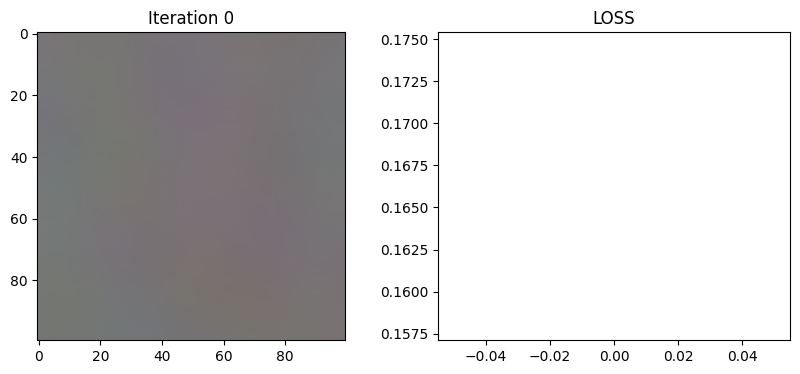

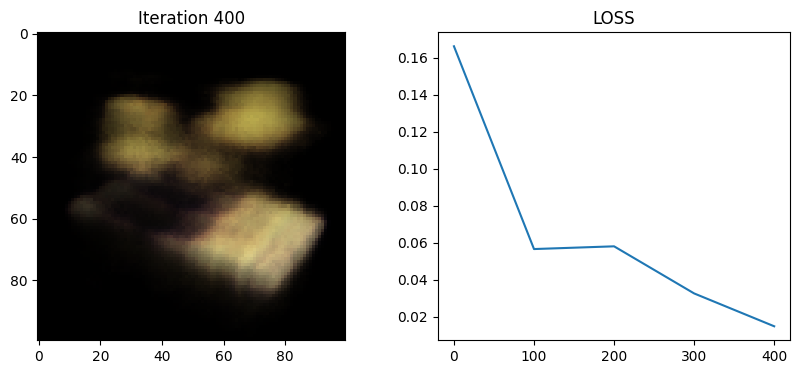

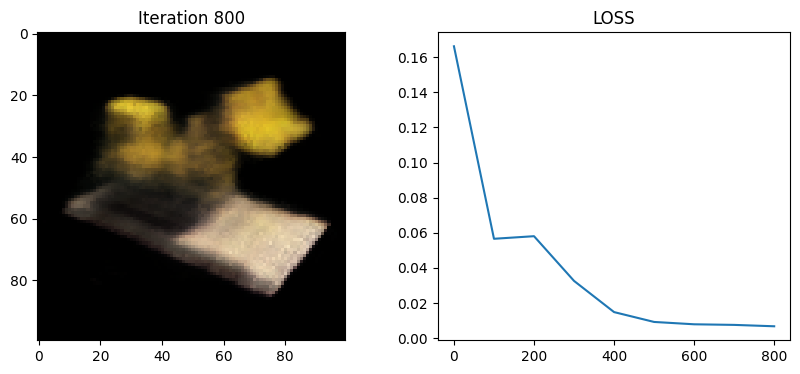

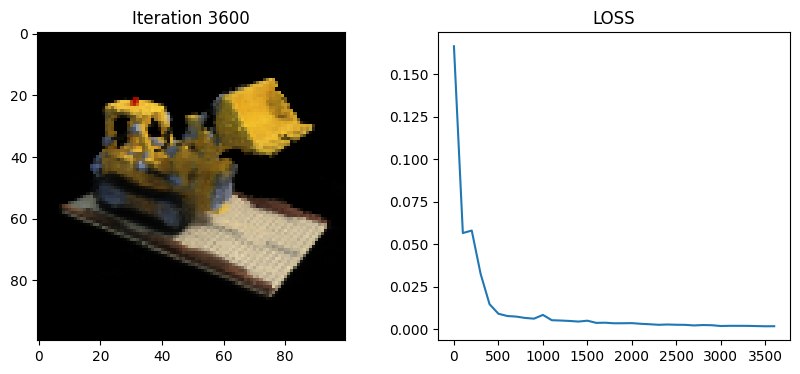

# Imports

In [ ]:
!pip install ipywidgets

import ipywidgets as widgets
from IPython.display import display, clear_output
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
!wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Loading


Loading in the tiny NeRF dataset we are given 106 images of size 100 x 100. The dataset itself contains the image, the camera pose for the image (a 4x4 transformation matrix), and the focal length of the camera.

['images', 'poses', 'focal']
(106, 100, 100, 3)
(106, 4, 4)
138.88887889922103
[[ 5.7199186e-01  3.4370849e-01 -7.4477494e-01 -3.0022840e+00]
 [-8.2025927e-01  2.3967843e-01 -5.1935434e-01 -2.0935845e+00]
 [-1.4901160e-08  9.0797514e-01  4.1902411e-01  1.6891403e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


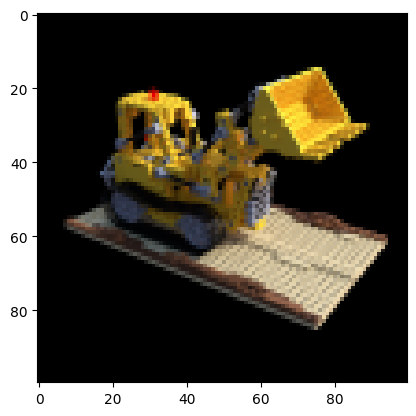

In [ ]:
data = np.load('tiny_nerf_data.npz')
print(list(data.keys()))
images = data['images']
poses = data['poses']
focal = data['focal']
print(images.shape)
print(poses.shape)
print(focal)

example = 52
example_img, example_pose = images[example], poses[example]
plt.imshow(example_img)
print(example_pose)

The NeRF model takes in positions $(x,y,z)$ and a direction vector $(\theta,\phi)$  thus we need to generate these inputs to sample points for each image in the dataset. To find the origin and direction for each image, we can utilize the information stored in the 4x4 camera matrix.

$\left[\begin{array}{llll}r_{11} & r_{12} & r_{13} & t_1 \\ r_{21} & r_{22} & r_{23} & t_2 \\ r_{31} & r_{32} & r_{33} & t_3\end{array}\right]$


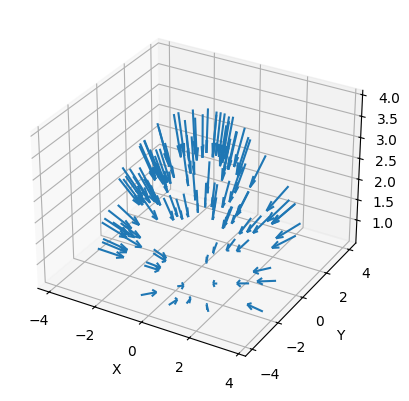

In [ ]:
def get_origins(poses):
    """
    generate origin rays for each camera

    Args:
    poses: camera poses

    Returns:
    rays: direction vector
    origins: xyz position
    """
    rays = np.stack([cam[:3, :3] @ [0, 0, -1] for cam in poses])
    origins = np.stack([cam[:3,-1] for cam in poses])
    rays = np.concatenate([rays, origins], axis=1)

    return rays, origins

rays, origins = get_origins(poses)
ax = plt.figure().add_subplot(projection='3d')
ax.quiver(origins[:,0], origins[:,1], origins[:,2],
          rays[:,0], rays[:,1], rays[:,2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('z')
plt.show()

Extending this to the entire image, we can generate a ray for every pixel. Each pixel in the image will have a different direction vector with its origin starting at the center of the camera. Since the camera is the same between all images, we can define a camera matrix containing each ray for each pixel and simply apply the rotation and translation to every ray to generate these values.

In [ ]:
img_size = images.shape[1]
xc = (torch.arange(img_size) - (img_size / 2 - 0.5)) / focal
yc = (torch.arange(img_size) - (img_size / 2 - 0.5)) / focal
(xc, yc) = torch.meshgrid(xc, -yc, indexing='xy')
camera_coords = torch.stack([xc, yc, torch.full_like(xc, -1)], dim=-1)

camera_coords = torch.Tensor(camera_coords).to(device)

In [ ]:
def get_rays(pose, camera_coords):
    """
    Apply the rotation matrix to all rays in a pose
    Args:
    poses: camera poses
    camera_coords: ray vectors for each pixel in a camera

    Returns:
    os: ray origins
    ds: ray directions
    """
    rot = pose[:3, :3]
    ds = torch.sum(camera_coords[..., None, :] * rot, dim = -1)
    os = (torch.Tensor(pose[:3, -1])).expand(ds.shape)
    return ds, os

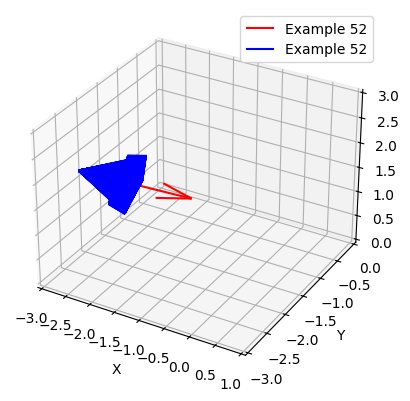

In [ ]:
poses = data['poses']
rays, origins = get_origins(poses)
poses = torch.Tensor(poses).to(device)
ax = plt.figure().add_subplot(projection='3d')

ds, os = get_rays(torch.Tensor(poses[example]), camera_coords)


ax.quiver(origins[example, 0], origins[example, 1], origins[example, 2],
         rays[example, 0], rays[example, 1], rays[example, 2], length=2, color='red', label=f"Example {example}")

ax.quiver(os[:,:, 0].cpu().numpy(), os[:,:, 1].cpu().numpy(), os[:,:, 2].cpu().numpy(),
          ds[:,:, 0].cpu().numpy(), ds[:,:, 1].cpu().numpy(), ds[:,:, 2].cpu().numpy(), length=1, color='blue', label=f"Example {example}")


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('z')
ax.legend()

ax.set_xlim([-3, 1])
ax.set_ylim([-3, 0])
ax.set_zlim([0, 3])

plt.show()

# Positional Encoding (Section 5.1)

An important aspects of the NeRF model is the usage of Positional Encoding. By mapping its inputs into higher dimensions, the model is better represent fine details.

Apply the positional encoding $\gamma$ to both viewing directions and position.

$\gamma(p) = \left( \sin \left( 2^0 \pi p \right), \cos \left( 2^0 \pi p \right), \cdots, \sin \left( 2^{L-1} \pi p \right), \cos \left( 2^{L-1} \pi p \right) \right) $ (eq. 4)

The function $\gamma(\cdot)$ is applied to each of the three coordinate values in $x$ and applied to each of the three components of the viewing direction vector $d$ with the values of L being 10 and 4 for the $x$ and $d$ respectively as described in the paper.

In [ ]:
def positional_encoding(x, L):
    """
    Map features X into higher dimensional space using positional encoding

    Args:
    x: values
    L: number of dimensions

    Returns:
    encodings: values in higher dimensional space
    """
    encodings = [x]
    for i in range(L):
        encodings.append(torch.sin(2 ** i * torch.pi * x))
        encodings.append(torch.cos(2 ** i * torch.pi * x))
    return torch.cat(encodings, dim=-1)

# Volume Rendering (Section 4)

The model itself represents the scene as a radiance field, a function that tells us how light will travel and interact through a scene. It is given by this equation:

$C(\mathbf{r})=\int_{t_{\mathrm{n}}}^{t_f} T(t) \sigma(\mathbf{r}(t)) \mathbf{c}(\mathbf{r}(t), \mathbf{d}) d t$, where $T(t)=\exp \left(-\int_{t_n}^t \sigma(\mathbf{r}(s)) d s\right)$ (eq. 1).

$C(r)$: The color observed along a ray $r$. This output is how we are able to generate new views of an object.\
$tn$ and $tf$: The range over which we are integrating. \
$r(t)$: The 3D position along the ray at distance $t$. It's given by $r(t) = o + td$, where $o$ is the ray's origin and $d$ is its direction.\
$\sigma(r(t))$: The volume density at position $r(t)$. It represents how much light is absorbed or scattered at that point.\
$c(r(t), d)$: The emitted color at position $r(t)$ in the direction d.\
$T(t)$: The accumulated transmittance along the ray up to a distance t. It tells us the probability of a point being empty space.

In other words, the terms we are integrating over tell us whether or not the ray continues past t, how dense the the point t is,and what the color is at that particular point t.

If the probability of the ray continuing past t is high, and the density of the point is also high, this probably means that the ray has only just hit the object. This will translate into the color term $c(r(t), d)$ being multipllied with the high density $\sigma$ resulting in a large color value. As the ray continues on its path, the probability of the ray hitting nothing would decrease. This in turn will reduce the contribution of these points to the final color value of the ray.

In order to generate these pointsa stratified sampling approach is utilized where the interval $[t_n, t_f]$ is partioned into $N$ evenly-spaced bins. One sample is then uniformly selected at random from within each bin:

$t_i \sim \mathcal{U}\left[t_n+\frac{i-1}{N}\left(t_f-t_n\right), t_n+\frac{i}{N}\left(t_f-t_n\right)\right]$ (eq 2).

Using these samples we can estimate $C(r)$ as:

$\hat{C}(\mathbf{r})=\sum_{i=1}^N T_i\left(1-\exp \left(-\sigma_i \delta_i\right)\right) \mathbf{c}_i$, where $T_i=\exp \left(-\sum_{j=1}^{i-1} \sigma_j \delta_j\right)$ (eq 3).
Where $\delta_i=t_{i+1}-t_i$ is the distance between each adjacent sample. This function itself can be reduced to $\alpha_i = 1-\exp(-\sigma_i\delta_i)$.

In other words, we can write the occlusion of a point $\alpha_i$ in terms of the density and distances between samples.


In [ ]:
def render_radiance_volume(rc, tc, ds, chunk_size, F):
    """
    calculate the radiance volume by integrating over the given points

    Args:
    rc: points sampled along each ray
    tc: corresponding offsets between each bin
    ds: direction vector for each ray
    chunk_size: the number of sampled points to be processed at a time
    F: the NeRF model which will give a density and color for each sampled point in a certain direction

    Returns:
    Cs:
    """
    # flatten query tensor to be input into MLP
    rc_flat = rc.reshape((-1, 3))

    # create individual ray for each sampled point on the ray
    ds_full = ds.unsqueeze(2).repeat(1, 1, rc.shape[-2], 1)
    ds_flat = ds_full.reshape((-1, 3))

    # generate the color value / density for each sampled point
    c = []
    sigma = []
    for idx in range(0, rc_flat.shape[0], chunk_size):
        rc_batch = rc_flat[idx : idx + chunk_size]
        ds_batch = ds_flat[idx : idx + chunk_size]
        c_i, sigma_i = F(rc_batch, ds_batch)
        c.append(c_i)
        sigma.append(sigma_i)

    c = torch.cat(c).reshape(rc.shape)
    sigma = torch.cat(sigma).reshape(rc.shape[:-1])

    # calculate distance between each sample along a ray
    delta = tc[..., 1:] - tc[..., :-1]

    # ensure each ray terminates by appending infinity to distances
    inf =  torch.Tensor([1e10]).expand(delta[..., :1].shape)
    delta = torch.cat([delta, inf.to(delta)], dim=-1)

    # scale each distance by the norm of the original vector
    # ensures that the final distance is prportional to the size of the ray it originates from
    delta = delta * ds.norm(dim=-1).unsqueeze(-1)

    # get the opaqueness of a certain point
    alpha = 1.0 - torch.exp(-sigma * delta)
    T_is = torch.cumprod(1.0 - alpha + 1e-10, -1)

    # ensure at least one sampled point
    T_is = torch.roll(T_is, 1, -1)
    T_is[..., 0] = 1.0

    # calcualte the weight that each sample provides to the final color
    ws = T_is * alpha
    Cs = (ws[..., None] * c).sum(dim=-2)
    return (Cs, ws)


# Hierarchical volume sampling (Section 5.2)

Another important aspect of the NeRF model is the usage of hierarchial volume sampling. By utilizing two networks, a coarse network and a fine network, they are able to generate more accurate representations of the data. By first sampling a set of $N_c$ locations and evaluating the coarse network at these locations, we can generate a more specific collection of sampling points where samples are biased towards areas that are more likely to have information. To do so, the alpha composited color from the coarse network is rewritten as a weighted sum along the ray.

$\hat{C}_c(\mathbf{r})=\sum_{i=1}^{N_c} w_i c_i, \quad w_i=T_i\left(1-\exp \left(-\sigma_i \delta_i\right)\right)$ (eq 5)

By nomalizing these weights we are able to generate a probability distribution function from which we can sample a new set of $N_f$ locations and evaluate the fine model over the union of these two sampled sets of data.

In [ ]:
def get_coarse(ds, os, Nc, ti_bin_edges, ti_size):
    """
    Generate corase datapoints

    Args:
    ds: ray vectors
    os: ray origin
    Nc: number of bins / samples per ray for coarse sampling
    t_bin_edges: bin edges along a ray
    ti_size: size of each bin

    Returns:
    rc: corase datapoints
    tc: offset value from bin edge
    """

    # generate random samples within N_c bins
    us = torch.rand(list(ds.shape[:2]) + [Nc]).to(ds)
    tc = ti_bin_edges + us * ti_size

    # calculate points along ray
    rc = os[..., None, :] + tc[..., :, None] * ds[..., None, :]
    return (rc, tc)

In [ ]:
def get_fine(ds, os, w, Nf, tc, t_far):
    """
    Generate fine datapoints centered around coarse datapoints with high weight values

    Args:
    ds: ray vectors
    os: ray origin
    w: weights from coarse sampling
    Nf: number of samples per ray for fine sampling
    tc: coarse datapoints
    tf: upper_bound

    Returns:
    rf_total: coarse + find datapoints
    tf_total: coarse + fine offset values
    """
    # normalize weights in order to create a probability distribution function
    w = w + 1e-5
    pdf = w / torch.sum(w, dim=-1, keepdim=True)

    # to utilize inverse transform sampling we need to create a Cumulative distribution function
    cdf = torch.cumsum(pdf, dim=-1)
    # starting from 0 probability
    cdf = torch.cat([torch.zeros_like(cdf[..., :1]), cdf[..., :-1]], dim=-1)

    # similar to earlier generate uniform samples of points
    us = torch.rand(list(cdf.shape[:2]) + [Nf]).to(w)

    # inverse transform sampling
    # find the matching index of the coarse sample. Since we are using a CDF the higher weights have a higher chance of being chosen in us
    idx = torch.searchsorted(cdf, us, right=True)

    # define intervals to get fine samples
    # lower bound
    # looking at depth, for each index we want to find index - 1 (the lower bound)
    # gather samples from tc at each idx - 1
    bot = torch.gather(tc, 2, idx - 1)

    # upper bound
    # need to address case where sampled point is the last sampled point by shifting sampled point back
    last_i = cdf.shape[-1]
    idx_adjusted = idx.clone()
    idx_adjusted[idx == last_i] = last_i - 1

    # now find the upper index for each index
    # gather samples from tc at each idx
    top = torch.gather(tc, 2, idx_adjusted)

    # undo shifting the last point back and set the upper bound to the end of t_far
    top[idx == last_i] = t_far

    # back to r(t) = o + td
    # generate random value between top and bot
    t_gap = top - bot
    us_f = torch.rand_like(t_gap).to(os)
    tf = bot + us_f * (top - bot)

    # combine coarse and fine samples
    (tf_total, _) = torch.sort(torch.cat([tc, tf.detach()], dim=-1), dim=-1)
    rf_total = os[..., None, :] + tf_total[..., :, None] * ds[..., None, :]
    return (rf_total, tf_total)

# Model

The input to the model is a 63 features after passing the input vector through positional encoding. It is then followed by 8 fully connected ReLU layers to process the input ray. The model also utilizes a skip connection at the 5th layer in order to increase fidelity. After the 8th layer, a linear layer is applied to produce a new feature representing the volume density $\sigma$. This output, with the sigma term removed, is then combined with the encoding of the direction vector, with an out channel of 128. A final linear layer converts the 128 channels into 3 channels, and a sigmoid layer is used to denote the RGB values of the output.

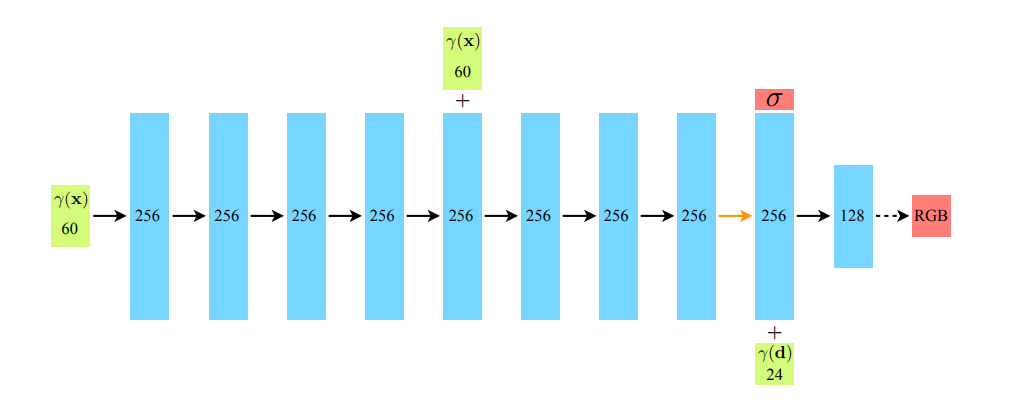

In [ ]:
class NeRF(nn.Module):
    def __init__(self, LP=10, LD=4, channels=256):
        super().__init__()
        # positional encoding parameters
        self.LP = LP
        self.LD = LD

        # feature dimension after encodings
        pos_features = 3 + 3 * 2 * LP
        dir_features = 3 + 3 * 2 * LD

        # 5 coordinate layers / 3 coordinate layers + skip connection
        self.pos1 = self.mlp(pos_features, channels, 5)
        self.pos2 = self.mlp(pos_features + channels, channels, 3)

        # density definition
        self.sigma = nn.Linear(channels, channels + 1)

        # feature vector from x + positional encoding of d (excluding density)
        self.dir = nn.Sequential(
            nn.Linear(channels + dir_features, channels // 2),
            nn.ReLU()
        )
        self.output_layer = nn.Sequential(
            nn.Linear(channels // 2, 3),
            nn.Sigmoid()
        )

    def mlp(self, features, channels, num_layers=5):
        """
        Create a multi-layer perceptron with ReLU activation

        Args:
        features: number of features
        channels: number of channels
        layers: number of layers

        Returns:
        nn.Sequential object
        """
        layers = []
        for _ in range(num_layers):
            layers.append(nn.Linear(features, channels))
            layers.append(nn.ReLU())
            features = channels
        return nn.Sequential(*layers)

    def forward(self, xs, ds):
        """
        predict colors and volume densities given 3D points and viewing direction

        Args:
        xs: 3D points
        ds: viewing direction

        Returns:
        c_t: predicted colors
        sigma: predicted volume densities
        """
        # encode positional values
        xs_encoded = positional_encoding(xs, self.LP)

        # normalize and encode directional vectors
        magnitude = ds.norm(p=2, dim=-1).unsqueeze(-1)
        ds = ds / magnitude
        ds_encoded = positional_encoding(ds, self.LD)
        # pass in positional values
        outputs = self.pos1(xs_encoded)
        outputs = self.pos2(torch.cat([xs_encoded, outputs], dim=-1))
        outputs = self.sigma(outputs)
        # generate density / colors
        sigma = torch.relu(outputs[:, 0])
        outputs = self.dir(torch.cat([ds_encoded, outputs[:,1:]], dim=-1))
        c = self.output_layer(outputs)
        return c, sigma

In [ ]:
def one_iteration(ds, os, Nc, ti_bin_edges, ti_size,
                  F_coarse, chunk_size,
                  Nf, tf,
                  F_fine):
    """
    Run through one iteration of the coarse and fine NeRF models.

    Returns:
    c_coarse: color values for the coarse model
    c_fine: color values for the fine model
    """
    (rc, tc) = get_coarse(ds, os, Nc, ti_bin_edges, ti_size)
    (c_coarse, w_coarse) = render_radiance_volume(rc, tc, ds, chunk_size, F_coarse)

    (rf, tf) = get_fine(ds, os, w_coarse, Nf, tc, t_far)
    (c_fine, _) = render_radiance_volume(rf, tf, ds, chunk_size, F_fine)
    return (c_coarse, c_fine)

# Training

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
F_coarse = NeRF().to(device)
F_fine = NeRF().to(device)

chunk_size = 1024 * 32
batch_img_size = 64
n_batch_pix = batch_img_size ** 2

lr = 5e-4
optimizer = torch.optim.Adam(list(F_coarse.parameters()) + list(F_fine.parameters()), lr=lr)
criterion = nn.MSELoss()
lrate_decay = 250
decay_steps = lrate_decay * 1000
decay_rate = 0.1

t_near = 1.0
t_far = 5.0
Nc = 64
Nf = 128
ti_size = (t_far - t_near) / Nc
ti_bin_edges = (t_near + torch.arange(Nc) * ti_size).to(device)

loss_vals = []
iternums = []
num_iters = 300000
display_every = 100

NeRF(
  (pos1): Sequential(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): ReLU()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): ReLU()
  )
  (pos2): Sequential(
    (0): Linear(in_features=319, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): ReLU()
  )
  (sigma): Linear(in_features=256, out_features=257, bias=True)
  (dir): Sequential(
    (0): Linear(in_features=283, out_features=128, bias=True)
    (1): ReLU()
  )
  (output_layer): Sequential(
    (0): Linear(in_features=128, out_features=3, bias=True)
    (1): Sigmoid()
  )
)

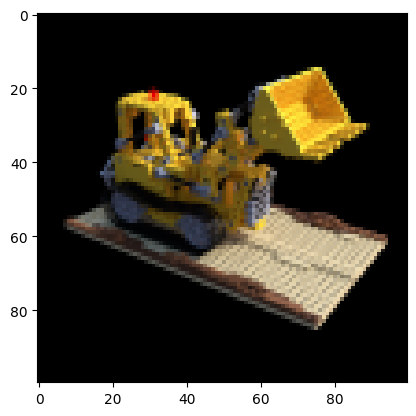

In [ ]:
seed = 7362
torch.manual_seed(seed)
np.random.seed(seed)

data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']

testing_idx = 52
plt.imshow(images[testing_idx])
test_img = torch.Tensor(images[testing_idx]).to(device)
test_pose = torch.Tensor(poses[testing_idx]).to(device)

all_idx = np.arange(images.shape[0])
train_idx = np.delete(all_idx, testing_idx)

images = torch.Tensor(images[train_idx])
poses = torch.Tensor(poses[train_idx])

ones_tensor = torch.ones((img_size ** 2,)).to(device)
pixel_distribution = ones_tensor / img_size ** 2

F_coarse.train()
F_fine.train()